In [ ]:
from IPython.display import display, Markdown, Latex

In [ ]:
from notebook.services.config import ConfigManager
cm = ConfigManager()

In [ ]:
cm.update('livereveal', {
              'width': 1000,
              'height': 600,
              'scroll': True,
})

In [55]:
# Let's set up nb kicker
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import bluesky.utils
bluesky.utils.install_nb_kicker()

In [ ]:
# Let's see if the required installation is available
import ophyd
import bluesky


# Select a read only variable which gives a new output every now and then
# I could use the simulation ones from ophyd. I prefer to use some real 
# device

# One read only device
sig_ro = 'TOPUPCC:rdCur'

# A second read only device
sig_ro2 = 'MCLKHX251C:freq'

# Furthermore let's use good practice: a single bluesky run engine
has_run_engine = False
try:
    RE
    has_run_engine = True
except NameError:
    pass
    
if not has_run_engine:
    RE = bluesky.RunEngine()
    
assert(callable(RE))

import collections

In [6]:
#Let's test that the epics variables are really available
import epics
import functools

# A little hack to minimize load on the real IOC's
@functools.lru_cache(maxsize=None)
def create_pv(name):
    t_pv = epics.PV(name)
    return t_pv

# This test should print some values.
# I do it directly using epics.PV to have direct control
# on connections etc ....
for ro_name in [sig_ro, sig_ro2]:
    a_pv = create_pv(ro_name)
    value = a_pv.value
    print(f'Epics PV {ro_name}: Got value {value}')

<h1> Introduction to Bluesky and Ophyd </h1>

Author: Pierre Schnizer

Material see https://github.com/TMsangohan/bact2/tree/master/tutorials



<h2> Scope of this lecture </h2>

Second part
   * recap on devices
   * events
   * plans

<h3> Bluesky naming conventions </h3>

Bluesky collaboration uses the following concpets:
* A control system (EPICS) is responsible for taking data
* This control system provides asynchronos and parallel access to the devices using variables
* It separates device abstraction from measurement plans
* In this concept:

    * `Ophyd` allows making devices accessible abstracted as classes with different methods
    * `Bluesky` provides measurement plans and the run engine
    * The run engine executes the plans by calling appropriate methods of the involved devices. 
      (This description is a bit imprecise and will be detailed further below)
      
    * Further modules
        * data broker: storing data
        * suitcase:    storing data (to files)
        * Liveplot:    plotting data

<h3> Ophyd abstraction: everything is a signal </h3>  

Comparison: `Unix everything is a file`

Ophyd:
* `Everything is a signal`
* Signals can be subscribed to
* Signals are used to encapsulate hardware access (for `ÈPICS`)
* Lifeplots can use them
* Bluesky run engine uses signals to gather device information
* See further down on event model to understand how it simplifies
  measurements

<h3> Device drivers rehearsal I /II</h3>

Device drivers (syncronous acquistion):
   * provides abstractions:
       * :meth:`trigger`: get device ready for collecting data, (commonly start acquisition)
       * :meth:`read`: collect data
       * :meth: `set`: set a device to

Devices provide:
   * methods that respond immediately:
       * these return typically values
       * e.g. :meth:`read`: returns values
   * methods that take some evaluation time:
       * these return a :class:`Status` object
       * device typically continues processing
         e.g by EPICS signal call handlers
       * caller responsible for checking that
         :any:`status.done` is set
       * RunEngine typically does that for us
       


<h3> Device drivers rehearsal II /II </h3>

recall: Status object: "beer garden buzzer"

Run Engine: central processing unit
See further down below

<h2> Device drivers: complete picture </h2>

* Covered:
   * synchronous devices
       * trigger, read
       * set
* Missing:
    * asnychronous devices
    * pause / resume
    

<h3> Asynchronos device drivers </h3>

Bluesky/ophyd terminology: "flyable devices"
Think data taken while a motor is moved.
Synchronisation ´by some not bluesky synchronisation method´: e.g. trigger cables

Device drivers (asynchronous acquistion):
   * provides abstractions:
       * :meth: `kickoff`: make device ready to take data.
         Status object finished: ready for taking data
       * :meth: `complete`: device finished taking data.
         Signaled by status object
       * :meth: `collect`: returns all data

I did not yet implement such a device.
Usage: e.g. booster bpm data 


<h3> Device overall setup I/II </h3>

* Main details given before.
* Now missing corners:
    * setting up a device:
        * :meth:`stage`:   Hands off my device
        * :meth:`unstage`: You can have it
    * supporting pausing:
        * :meth:`pause`:   stop what you are doing
        * :meth:`resume`:  go on

* Staging Concept:
    * staging: implement typically:
        * check that device is ready
        * reserve usage
    * unstaging: 
        * reverse what staging did if necessary
 

<h3> Device overall setup II/II </h3>

 
*NB* staging:
   * a device can only be staged *once*
   * it can be unstaged an infinite number of times

<h3> Staging device: Example I/II </h3>

In [7]:
from ophyd import Device
class MyDevice(Device):
    def stage(self):
        '''Expected to return immediately
        '''
        # This call is essential
        # It ensures that the device is only staged once
        return super().stage()
    
    def unstage(self):
        # I think Device does not implement a unstage method
        # super().unstage()
        pass

<h3> Staging device: Typical implementation II/II </h3>

In [8]:
from ophyd import Device
class MyDevice(Device):
    def stage(self):
        '''Expected to return immediately
        '''
        self.checkDevice()
        return super().stage()
    
    def unstage(self):
        '''revert the effect
        '''
        

<h3> Pausing a device </h3>

Typical implementation:
* stop motor and wait to continue
* (close shutter of streak camera ?)

Standard method forseen:
* `RunEngine`
    * provides interruption (e.g. `Ctrl + C ` if run interactively)
    * allows registering suspenders: 
        * e.g. for exclusion of injection period
    * devices:
        * require to be informed: stop motor movement
        * need to be resumed: (request to reinject beam current)
        
I used it from plans, but did not implement a device yet

<h3> Information on a device </h3>

In [9]:
mydev = MyDevice(name = 'mydev')
mydev.describe()

OrderedDict()

In [10]:
od = collections.OrderedDict()
mydev.configure(od)

(OrderedDict(), OrderedDict())

In [11]:
mydev.read_configuration()

OrderedDict()

In [12]:
mydev.connected

True

In [13]:
mydev.wait_for_connection()

<h2> Bluesky plans I/II </h2>

Bluesky separates:
   * device implementation: `ophyd.Devices`
   * measurement plans:  `bluesky plans`
        
Idea: separate
   * measurement devices from plans
   * allows
        * device library
        * reusable plans
        
Connection: `RunEngine`:
   * Plans: create messages
   * RunEngine:
 

<h2> Bluesky plans II/II</h2>

Connection: `RunEngine`:
   * Plans: create messages
   * RunEngine:
        * processes messages
        * calls appropriate methods of devices
        * checks
            * monitors
            * suspenders
        * distributes data:
            * e.g. liveplots
            * e.g. databroker $\to$ storage

<h3> Bluesky plans </h3>

Implementation
* Message passing: 'small talk'
* No need to worry: 
    * bluesky provides standard plans 
    * provides plan stubs: code snips $\to$ simplify implementation


Following:
1. Short list of standard plans
1. examples with standard plans
1. writing ones plans

<h3> Bluesky standard plans </h3>

See tutorial https://nsls-ii.github.io/bluesky/plans.html 

Module :mod:`bluesky.plans`

provides plans (here only selection and simplified):
* executing measurements: `count`
* scanning :
    * move an actuator (motor)
    * take measurements from detectors
* relative scanning: (some issues experience)
* grid scanning: snake and direct
* spirals

<h3> Examples </h3>

In [14]:
import bluesky.simulators
from ophyd.sim import motor, motor2, det

<h4> Plan Summary </h4>

In [15]:
import bluesky.plans
plan = bluesky.plans.count([det], 3)
bluesky.simulators.summarize_plan(plan)

=================================== Open Run ===================================
  Read ['det']
  Read ['det']
  Read ['det']
================================== Close Run ===================================


In [16]:
plan = bluesky.plans.scan([det], motor,  1, 11, 3)
bluesky.simulators.summarize_plan(plan)

=================================== Open Run ===================================
motor -> 1.0
  Read ['det', 'motor']
motor -> 6.0
  Read ['det', 'motor']
motor -> 11.0
  Read ['det', 'motor']
================================== Close Run ===================================


<h4> Grid scans </h4>

Scan a grid:
* with and without snake

{'path': <matplotlib.lines.Line2D at 0xa8897b8>,
 'events': <matplotlib.collections.PathCollection at 0xbb24a20>}

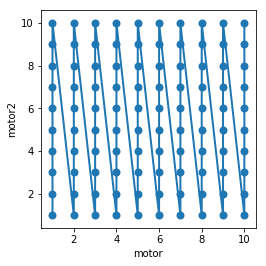

In [17]:
snake = False
plan = bluesky.plans.grid_scan([], 
                               motor,  1, 10, 10, 
                               motor2, 1, 10, 10, snake)
bluesky.simulators.plot_raster_path(plan, 'motor', 'motor2')

{'path': <matplotlib.lines.Line2D at 0xbdbb358>,
 'events': <matplotlib.collections.PathCollection at 0xbdbb5f8>}

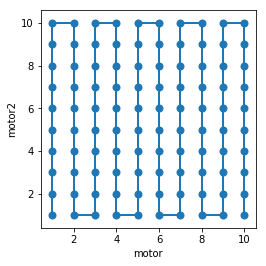

In [18]:
snake = True
plan = bluesky.plans.grid_scan([], 
                               motor,  1, 10, 10, 
                               motor2, 1, 10, 10, snake)
bluesky.simulators.plot_raster_path(plan, 'motor', 'motor2')

<h4> Spiral </h4>

e.g. 
* searching for an obstacle limiting aperture using a steerer bump
* Liveplot!

{'path': <matplotlib.lines.Line2D at 0xc677ef0>,
 'events': <matplotlib.collections.PatchCollection at 0xc67f438>}

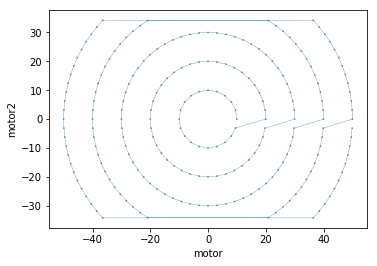

In [19]:
x_motor, y_motor = motor, motor2
x0, y0 = 0, 0
x_range, y_range = 50 * 2, 35 * 2
dr = 10
ntheta = 20
plan = bluesky.plans.spiral([], x_motor, y_motor,
                            x0, y0, x_range, y_range, 
                            dr, ntheta)
bluesky.simulators.plot_raster_path(plan, 'motor', 'motor2', probe_size=.3, lw=.3)

**Warning**

*The spiral covers a rectangle* 

{'path': <matplotlib.lines.Line2D at 0xc69f6a0>,
 'events': <matplotlib.collections.PatchCollection at 0xc69f710>}

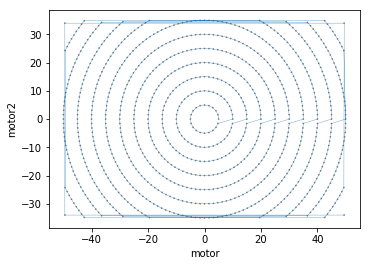

In [20]:
x_motor, y_motor = motor, motor2
x0, y0 = 0, 0
x_range, y_range = 50 * 2, 35 * 2
dr = 5
ntheta = 20
plan = bluesky.plans.spiral([], x_motor, y_motor,
                            x0, y0, x_range, y_range, 
                            dr, ntheta)
bluesky.simulators.plot_raster_path(plan, 'motor', 'motor2', probe_size=.3, lw=.3)

<h4> Square spiral </h4>

{'path': <matplotlib.lines.Line2D at 0xc9685f8>,
 'events': <matplotlib.collections.PathCollection at 0xc968b38>}

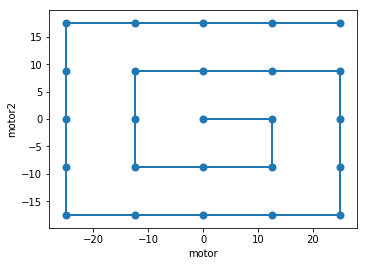

In [21]:
x_motor, y_motor = motor, motor2
x0, y0 = 0, 0
x_range, y_range = 50, 35
x_num = 5
y_num = 5
plan = bluesky.plans.spiral_square([], x_motor, y_motor,
                            x0, y0, x_range, y_range, 
                            x_num, y_num)
bluesky.simulators.plot_raster_path(plan, 'motor', 'motor2')

{'path': <matplotlib.lines.Line2D at 0xc987f98>,
 'events': <matplotlib.collections.PatchCollection at 0xc9af080>}

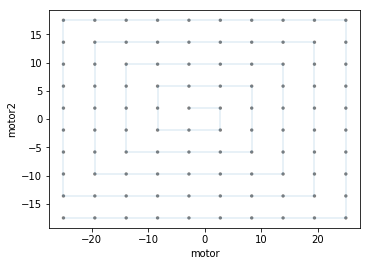

In [22]:
x_motor, y_motor = motor, motor2
x0, y0 = 0, 0
x_range, y_range = 50, 35
x_num = 10
y_num = 10
plan = bluesky.plans.spiral_square([], x_motor, y_motor,
                            x0, y0, x_range, y_range, 
                            x_num, y_num)
bluesky.simulators.plot_raster_path(plan, 'motor', 'motor2', probe_size=.3, lw=.2)

<h4> Fermat Spiral </h4>

{'path': <matplotlib.lines.Line2D at 0xc732630>,
 'events': <matplotlib.collections.PatchCollection at 0xc7326d8>}

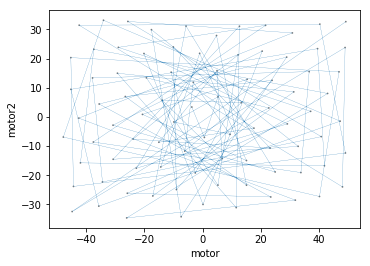

In [23]:
x_motor, y_motor = motor, motor2
x0, y0 = 0, 0
x_range, y_range = 50 * 2, 35 * 2
dr = 5
factor = 1
plan = bluesky.plans.spiral_fermat([], x_motor, y_motor,
                            x0, y0, x_range, y_range, 
                            dr, factor)
bluesky.simulators.plot_raster_path(plan, 'motor', 'motor2', probe_size=.3, lw=.2)

{'path': <matplotlib.lines.Line2D at 0xc837358>,
 'events': <matplotlib.collections.PatchCollection at 0xc8373c8>}

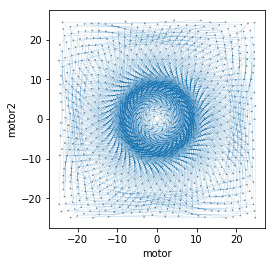

In [24]:
x_motor, y_motor = motor, motor2
x0, y0 = 0, 0
x_range, y_range = 25 * 2, 25 * 2
dr = 1
factor = 1
plan = bluesky.plans.spiral_fermat([], x_motor, y_motor,
                            x0, y0, x_range, y_range, 
                            dr, factor)
bluesky.simulators.plot_raster_path(plan, 'motor', 'motor2', probe_size=.2, lw=.1)

<h3> Coding one own plans </h3>

Advantage: 
* Full control
* Allows injection of meta data
* Allows "easier translation" of exisiting procedual code

Disadvantage:
* Adhere to standards:
    * Device staging
    * Open runs
* Generator interface: `yield`, `yield from`

But one gets the drill

<h3> Coding Plans: naming conventions </h3> 


In [26]:
from bluesky import plan_stubs as bps, preprocessors as bpp

<h3> Coding plans: bluesky provisions </h3>
    
* Plan stubs:
    * provide the *code snips* of the plans without:
        * staging management
        * run management
    * thus simple reuse
* preprocessors:
    * simplify managment of
        * staging
        * run

Let's see an example

<h4> Coding plan: example: simple motor movement </h4>



In [27]:
def sleepy_plan(motor, positions):
    "Step a motor through a list of positions with 1-second delays between steps."
    for position in positions:
        yield from bps.mv(motor, position)
        yield from bps.sleep(.3)

* puts motor to position one after the other using `bps.mv`
* typical `EPICS.PV`: assining a value to the variable
* **NB** `yield from`: messages are generated
* **NB** use `bps.sleep` not `time.sleep`: Asynchronous frame work!
* Common practise: settle time $\to$ device feature!

In [28]:
positions = range(8)
plan = sleepy_plan(motor, positions)
bluesky.simulators.summarize_plan(plan)

motor -> 0
motor -> 1
motor -> 2
motor -> 3
motor -> 4
motor -> 5
motor -> 6
motor -> 7


<h3> Fixing the plan </h3>

Using decorators:
* Staging
* Runs

Could be made by hand but: error handling
Let's trust our friends

In [29]:
def motor_stepper(motor, positions):
    # Add some meta data
    _md = {
        'plan_name' : 'motor_stepper',
    }
    # Stage our device
    @bpp.stage_decorator([motor])
    # Make run id
    @bpp.run_decorator(md = _md)
    def motor_stepper_inner(motor, positions):
        "Step a motor through a list of positions with 1-second delays between steps."
        for position in positions:
            yield from bps.mv(motor, position)
            
    return (yield from motor_stepper_inner(motor, positions))

In [30]:
positions = range(4)
plan = motor_stepper(motor, positions)
bluesky.simulators.summarize_plan(plan)

=================================== Open Run ===================================
motor -> 0
motor -> 1
motor -> 2
motor -> 3
================================== Close Run ===================================


<h4> Plan good practise </h4>

Plans should:
   * add their arguments to the metadata
   * that it can be "reexcuted"

In [31]:
def motor_stepper(motor, positions, md = None):
    # Add some meta data
    _md = {
        'plan_args': {'motor': motor, 'positions': positions},
        'plan_name' : 'motor_stepper',
    }
    _md.update(md or {})
    
    @bpp.stage_decorator([motor])
    @bpp.run_decorator(md = _md)
    def motor_stepper_inner(motor, positions):
        "Step a motor through a list of positions with 1-second delays between steps."
        for position in positions:
            yield from bps.mv(motor, position)
            
    return (yield from motor_stepper_inner(motor, positions))

In [32]:
positions = range(4)
plan = motor_stepper(motor, positions)
bluesky.simulators.summarize_plan(plan)

=================================== Open Run ===================================
motor -> 0
motor -> 1
motor -> 2
motor -> 3
================================== Close Run ===================================


<h4> Taking data </h4>

* Use method  `bps.trigger_and_read`
* Can be split in 
    * trigger: `bps.trigger`
    * read:    `bps.read`
    * side comment: can be split for different groups
      difference for fast and slow devices

<h3> Adding a logic to the plan </h3>

Shown:
1. Standard plans
2. simple plans
3. plan stubs and plans

Finish picture:
* conect to an external "simulation"
* e.g. support for "reinforcement training"
* illustrated using a simple connector
    * connector
    * plan

<h4> Connector implementation </h4>

* Here very simple approach
* generaters an iterator: used to hand over data to the plan
* callable $\leftarrow$ plan returns value

In [33]:
class Simulator:
    vals = range(4)
    def __init__(self):
        self._iterate = True
    def __iter__(self):
        for val in self.vals:
            if self._iterate:
                yield val
            else:
                break
    def __call__(self, val):
        val = int(round(val))
        if val:
            self._iterate = False

<h4> Plan implementation </h4>

Pretty  straight forward:
   * iterate over set values / next position
   * return the read value to connector / simulator


In [34]:
from bluesky.utils import separate_devices, Msg

def react_to_reading(det, motor, simulator, signal_name):
    #@bpp.stage_decorator([det, motor])
    #@bpp.run_decorator(md = {})
    def _run_all(det, motor, simulator, signal_name):
        for next_pos in simulator:
            yield from bps.mv(motor, next_pos)
            yield from bps.trigger([det, motor])
            
            val = None
            val = ( yield from bps.read(det) )
            # Normally the following code should read the data
            #for d in separate_devices([det, motor]):
            #    cur_det = yield Msg('read', d)
            #    if cur_det is not None and signal_name in cur_det:
            #        val = cur_det[signal_name]['value']
            if val is None:
                val = det.value
            simulator(val)
            assert(val is not None)
            print(next_pos, val)
    
    return (yield from _run_all(det, motor, simulator, signal_name))

In [35]:
from ophyd.sim import motor, det

In [36]:
s = Simulator()
plan = react_to_reading(det, motor, s, 'det')
bluesky.simulators.summarize_plan(plan)

motor -> 0
0 1.0


In [37]:
det.value

1.0

<h2> Data model </h2>

* Core concept of Bluesky 
    * Plans create Messages
    * Messages proccessed by Run Engine
    * Typically Messages create events
    * Events are published to subscribes: e.g. data broker
    
https://blueskyproject.io/event-model/

<h3> Data Model: Overview I/II </h3>

Full Overview see https://blueskyproject.io/event-model/data-model.html#overview

Selection:
* Run Start Document: metadata experimeent start 
* Run Stop Document: Metadata end of measurement 
* Event: a single measurement: typically data retrieved by ``read` request
* Event Descriptor: ton's of detais for the tevent ....

Graphic: see next slide
[Event Model](https://blueskyproject.io/event-model/_images/document-generation-timeline.svg)


<h3> Data Model: Overview II/II </h3>

Graphic: see next slidie
![Event Model](https://blueskyproject.io/event-model/_images/document-generation-timeline.svg)

<h2> Data model: Usage </h2>

* Each singe measurement is one event
* Example for processing: e.g. LivePlotting / Callbackbase
* E.g. LivePlot is implemented in that manner
* Passed to RunEngine $\to$ run enigne sends replies

[Call back base on github](https://github.com/bluesky/bluesky/blob/839b86f2299d55aef4828e4a835f8c18f1f007da/bluesky/callbacks/core.py#L61)

In [42]:
# https://github.com/bluesky/bluesky/blob/839b86f2299d55aef4828e4a835f8c18f1f007da/bluesky/callbacks/core.py#L61
# spurce ..
class CallbackBase:
    log = None

    def __call__(self, name, doc):
        "Dispatch to methods expecting particular doc types."
        return getattr(self, name)(doc)

    def event(self, doc):        pass
    def start(self, doc):        pass
    def stop(self, doc):         pass    
    def bulk_events(self, doc):  pass
    def resource(self, doc):     pass
    def datum(self, doc):        pass
    def bulk_datum(self, doc):   pass
    def descriptor(self, doc):   pass

<h2> Event model: Lifeplot implementation </h2>

Not functional code, but gives the idea: see 
[Live Plotting](https://github.com/bluesky/bluesky/blob/839b86f2299d55aef4828e4a835f8c18f1f007da/bluesky/callbacks/mpl_plotting.py#L42) for real implementation

In [44]:
class LivePlotting(CallbackBase):
    x_var_name = 'some_name'
    y_var_name = 'some_name'    
    def start(self, doc):
        '''
        Initialise canvas
        Make lines data caches etc
        '''
    def stop(self, doc):
        '''Check if data has been received and report to user if none
        '''
        pass
    def event(self, doc):
        '''Process data
        '''
        x = doc['data'][self.x_var_name]
        y = doc['data'][self.y_var_name]
        # Time stamps
        xt = doc['timestamps'][self.x_var_name]
        # Add data to lines    

<h2> Life plotting </h2>

* Usage examples for standard scalar values
    * plotting y vs x 
    * plotting y vs index
    * plotting y vs passed time
* Combining plots in a figure

In [47]:
from bluesky.callbacks import LivePlot

Defining the plot

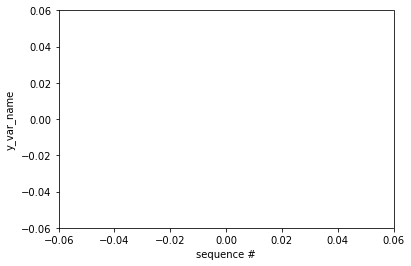

In [50]:
LivePlot('y_var_name', x = 'x_var_name')

<h3> Combining with the  run engine </h3>

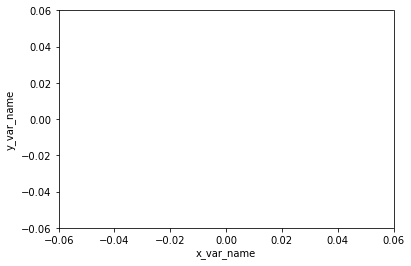

In [53]:
plots = [
    LivePlot('y_var_name', x = 'x_var_name')
];

<h3> Execution </h3>

In [54]:
# RE(plan, plots)

**NB**:
* RunEngine `__call__` method picky with commas, arguments:
   ``RE(plan, plots)``
* I fall into that pothole
* Therefore I prefer to call it with one *or* two variables

<h3> Setting up a combination of plots </h3>

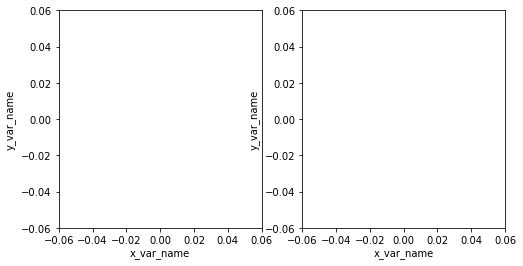

In [59]:
fig = plt.figure(1, figsize = [8, 4])
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
plots = [
    LivePlot('y_var_name', x = 'x_var_name', ax = ax1, legend_keys = ['view1']),
    LivePlot('y_var_name', x = 'x_var_name', ax = ax2, legend_keys = ['view2']),
];
# RE(plan, plots)

<h2> Bluesky in BESSY II Control room </h2>

* Python version:
   * Bluesky requires Python 3.6 or newer (f-type string)
   * Thans to Thomas and Tom: Containered version
* My best practise:
   * Separate:
       * device drivers
       * plans
       * customized live plots
   * use shell for testing
   * *Please* refrain from overloading notebooks